<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Рекуррентные сети 3»

Преподаватель: Даниил Корбут, Алексей Миронов, Татьяна Булгакова, Светлана Медведева, Артём Качалкин, Никита Селин

Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/)

1. Обучите на них seq2seq по аналогии с занятием.

2. Оцените полученное качество

3. Попробуйте добавить +1 рекуррентный слой в encoder и decoder

4. Попробуйте заменить GRU ячейки на lstm-ячейки

Оцените качество во всех случаях

*5. Добавить в лекционный ноутбук, в функцию train, обучение батчами.

## Импорт библиотек и пользовательские функции

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
plt.switch_backend('agg')
%matplotlib inline

In [2]:
from google.colab import drive
from google.colab import files

In [3]:
from io import open
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Загрузка датасета

In [4]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2024-01-02 18:48:34--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16065699 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.32M  35.6MB/s    in 0.4s    

2024-01-02 18:48:34 (35.6 MB/s) - ‘rus-eng.zip’ saved [16065699/16065699]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [5]:
!tail rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

## 2. Предобработка датасета

Грануляция на уровне слов. name - название языка. 3 вида словарей в классе - Word2index ( слово-индекс), index2word (наоборот) b word2count (слово и кол-во его применений). 2 метода - добавить слово и добавить предложение. При этом, если слово не встречалось ранее, оно добавляется во все словари. Если встречалось - значение словаря word2count для данного слова увеличивается на 1

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Превращаем кодировку Unicode В Ascii, преобразуем в нижний регистр. Удаляем все символы, которые не являются буквами латинского алфавита,  точкой, вопросом, восклицательным знаком или пробелои
Ищем . , ? или ! . Если находим - вставляем перед ними пробел. Таким образом, точка, вопрос или восклицательный знак ставноятся отдельным токеном

In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def readLangs(lang1, lang2, reverse=False):
    """Возвращает названия языков с которого переводят, на которой переводят,
    и пару предложений на этих языках"""
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('rus.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Внесем ограничения на пары. Берем только те, которые длиной меньше 10 токенов и начинаются с eng_prefixes

In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 487600 sentence pairs
Trimmed to 28240 sentence pairs
Counting words...
Counted words:
rus 10119
eng 4289
['она какая то грустная .', 'she seems sad .']


In [11]:
# Это общее кол-во пар предложений
# Разделим их на train, val, test
len(pairs)
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
len(train_pairs), len(test_pairs)

(22592, 5648)

The Encoder
-----------





In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

The Decoder
-----------




In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size) # рАзмерость скрытого представления в размерность словаря
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [14]:
def indexesFromSentence(lang, sentence):
  # переводит преложение в последовательность индексов слов
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
  # превращаем последовательность индексов слов в тензор
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    # добавляем еще одну размерность
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [15]:
teacher_forcing_ratio = 0.5

# обучение на 1 паре предложений
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # Из датасета случайным образом выбираются пары предложений, преобразуются в тензоры.
    # В результате имеем список теноров длиной n_iters
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    # training_pairs = [tensorsFromPair(random.choice(pairs))
    #                   for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        #
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        num_layers = encoder.num_layers

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 3. Обучите на них seq2seq по аналогии с занятием.

5m 52s (- 82m 19s) (5000 6%) 3.1051
11m 21s (- 73m 52s) (10000 13%) 2.6268
17m 7s (- 68m 31s) (15000 20%) 2.3543
23m 55s (- 65m 47s) (20000 26%) 2.1756
30m 35s (- 61m 10s) (25000 33%) 2.0381
36m 29s (- 54m 44s) (30000 40%) 1.8737
42m 12s (- 48m 14s) (35000 46%) 1.7370
47m 45s (- 41m 47s) (40000 53%) 1.6667
53m 17s (- 35m 31s) (45000 60%) 1.5756
59m 10s (- 29m 35s) (50000 66%) 1.4823
64m 58s (- 23m 37s) (55000 73%) 1.4041
70m 37s (- 17m 39s) (60000 80%) 1.3424
76m 12s (- 11m 43s) (65000 86%) 1.2759
82m 1s (- 5m 51s) (70000 93%) 1.1773
88m 47s (- 0m 0s) (75000 100%) 1.1462


<Figure size 640x480 with 0 Axes>

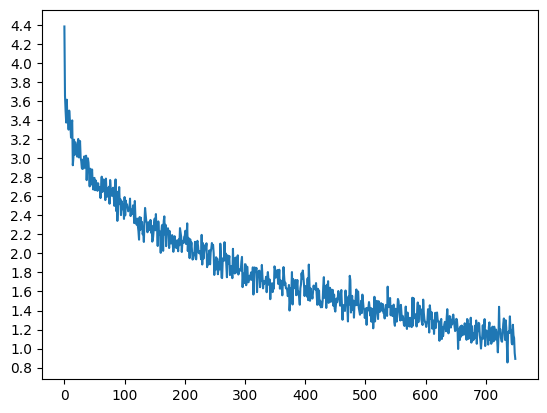

In [21]:
hidden_size = 256
num_layers = 1
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, num_layers).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, num_layers).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

## 4. Оцените полученное качество

In [22]:
# Оцена качества производится на тестовых данных
evaluateRandomly(encoder1, decoder1)

> ты же не канадка ?
= you aren t canadian are you ?
< you aren t canadian are you ? <EOS>

> я еще здесь .
= i m still here .
< i m still here . <EOS>

> я устал играть в игры .
= i m tired of playing games .
< i m tired of the tennis . <EOS>

> я ничего не говорю .
= i m not saying anything .
< i m not convinced of anything . <EOS>

> я не пытаюсь тебя напугать .
= i m not trying to scare you .
< i m not trying to to you . <EOS>

> ты очень милыи .
= you re very nice .
< you re very disorganized . <EOS>

> она и не богата и не знаменита .
= she s neither rich nor famous .
< she is not very wrong . <EOS>

> он совершенен во всем .
= he s perfect at everything .
< he s perfect at everything . <EOS>

> по понедельникам мы не работаем .
= we re closed on mondays .
< we re working on the phone . <EOS>

> вас разыскивает полиция .
= you re wanted by the police .
< you re being watched . <EOS>



## 5. Попробуйте добавить +1 рекуррентный слой в encoder и decoder

In [23]:
hidden_size = 256
num_layers = 2
# Изменила классы EncoderRNN и DecoderRNN, добавив туда параметр num_layers, но предыдущую модель пересчитывать не стала
# По идее, должна сработать при num_layers=1
encoder2 = EncoderRNN(input_lang.n_words, hidden_size, num_layers).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words, num_layers).to(device)


In [ ]:
trainIters(encoder2, decoder2, 75000, print_every=5000)

9m 16s (- 129m 53s) (5000 6%) 3.1574
18m 7s (- 117m 50s) (10000 13%) 2.6698


##6. Оцените полученное качество

In [59]:
evaluateRandomly(encoder2, decoder2)

> прости что наорал на тебя вчера .
= i m sorry for yelling at you yesterday .
< i m sorry i yelled at you <EOS>

> я ваша родственница .
= i m related to you .
< i m your . . <EOS>

> ты не по адресу .
= you re barking up the wrong tree .
< you re not on . <EOS>

> вы же не торопитесь ?
= you re not in a hurry are you ?
< you re not a are are you ? <EOS>

> он слеп как крот .
= he s as blind as a bat .
< he s as as as a . . <EOS>

> я недостаточно опытен .
= i m not experienced enough .
< i m not talking enough . <EOS>

> ты совсем не такои как мы .
= you re very different from us .
< you re not like us us . <EOS>

> я в беде .
= i am in deep water .
< i m in danger . <EOS>

> тебе нельзя в эту комнату .
= you aren t allowed in this room .
< you re not allowed in this room . <EOS>

> они танцуют .
= they re dancing .
< they re normal . <EOS>



## 7. Попробуйте заменить GRU ячейки на lstm-ячейки

In [66]:
# Defining the Encoder part of the model
class Encoder(nn.Module):
    # В параметры добавлен embedding_size
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)
        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)
        return hidden, cell

    # def initHidden(self):
    #     return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [61]:
# Defining the Decoder part

class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)
        return predictions, hidden, cell

    # def initHidden(self):
    #     return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [62]:
# Defining the complete model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        # target_vocab_size = len(english.vocab)
        target_vocab_size = output_lang.n_words

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [63]:
# Hyperparameters
num_epochs = 20
learning_rate = 0.001
batch_size = 64
# Model hyperparameters
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# input_size_encoder = len(german.vocab)
input_size_encoder = input_lang.n_words
# input_size_decoder = len(english.vocab)
input_size_decoder = output_lang.n_words
# output_size = len(english.vocab)
output_size = output_lang.n_words
encoder_embedding_size = 300
decoder_embedding_size = 300

hidden_size = 1024
num_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

In [67]:
# Изменила классы EncoderRNN и DecoderRNN, добавив туда параметр num_layers, но предыдущую модель пересчитывать не стала
# По идее, должна сработать при num_layers=1
encoder3 = Encoder(input_size_encoder,
                      encoder_embedding_size,
                      hidden_size,num_layers,
                      enc_dropout).to(device)


decoder3 = Decoder(input_size_decoder,
                      decoder_embedding_size,
                      hidden_size,output_size,num_layers,
                      dec_dropout).to(device)

In [ ]:
model = Seq2Seq(encoder3, decoder3).to(device)

## 5. Добавить в лекционный ноутбук, в функцию train, обучение батчами

In [ ]:
# Dataset и Dataloader как в предыдущем дз
BATCH_SIZE=100
train_dataset = torch.utils.data.TensorDataset(train_pairs[:, 0], train_pairs[:,1])
train_data = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(test_pairs[:, 0], test_pairs[:,1])
test_data = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [ ]:
teacher_forcing_ratio = 0.5

# обучение на 1 паре предложений
def train_(input_tensor, target_tensor, encoder, decoder, optimizer, criterion, max_length=MAX_LENGTH):

    model = Seq2Seq(encoder, decoder).to(device)
    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters_batch(encoder, decoder, n_iters, print_every=10, plot_every=1, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    num_batches = n_iters // batch_size
    for iter in range(num_batches):
        for input_tensor_batch, target_tensor_batch in train_data:
          input_tensor_batch, target_tensor_batch = input_tensor_batch.to(device), target_tensor_batch.to(device)
          loss = train_(input_tensor_batch, target_tensor_batch, encoder,
                      decoder, optimizer, criterion)
          print_loss_total += loss
          plot_loss_total += loss

        if iter % print_every == 0:
          print_loss_avg = print_loss_total / print_every
          print_loss_total = 0
          print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                          iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
          plot_loss_avg = plot_loss_total / plot_every
          plot_losses.append(plot_loss_avg)
          plot_loss_total = 0

    showPlot(plot_losses)